In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassConfusionMatrix
from torch.utils.data import Dataset, DataLoader

import cv2
import numpy as np
import os
import glob as glob
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from collections import Counter

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


from torch.utils.tensorboard import SummaryWriter
import numpy as np
writer = SummaryWriter()


In [26]:
valid_data_path = './dataset/valid_example/images/'
valid_lbl_path = './dataset/valid_example/labels/'

CLASSES = [ 
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare'
]

NUM_CLASSES = len(CLASSES) 
NUM_WORKERS = 4
BATCH_SIZE = 32
RESIZE_TO = 640 
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4 
PIN_MEMORY = True
CHECKPOINT_FILE = "./checkpoint/checkpoint.pth.tar"

S = [RESIZE_TO // 32, RESIZE_TO // 16]

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
] 

scale = 1.1

In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [28]:

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=RESIZE_TO),
        A.PadIfNeeded(
            min_height=RESIZE_TO, min_width=RESIZE_TO, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [29]:

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 4],
    (128, 3, 2),
    ["B", 6],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 6],
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, 3 * (num_classes + 5), bn_act=False, kernel_size=1
            ),
        )
        
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

class MelNet(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels=in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3

        return layers

if __name__ == "__main__": 
    model = MelNet(num_classes=NUM_CLASSES)


In [30]:

def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    
    while bboxes:
        chosen_box = bboxes.pop(0) 
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ] 
        
        bboxes_after_nms.append(chosen_box)
     
    return bboxes_after_nms
    
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [31]:
class MelNetDataset(Dataset):
    def __init__(
        self, img_dir, label_dir, anchors, S = [13, 26], C = 20, transforms=None
    ):
        self.all_images = glob.glob(f"{img_dir}/*")       
        self.labels_path = label_dir
        self.transforms = transforms
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 2
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, index):
        image_path = self.all_images[index]
        image_name = image_path.split(os.path.sep)[-1]
        image = np.array(Image.open(image_path).convert("RGB"))
        
        lbl_filename = image_name[:-4] + '.txt'
        lbl_path = os.path.join(self.labels_path, lbl_filename)
        
        boxes = []
        labels = []  
        box_label = []
         
        with open(lbl_path, 'r') as f:
            label_lines = f.readlines()
            for label_line in label_lines:
                lbl = label_line.split(' ')
                xc = float(lbl[1]) 
                yc = float(lbl[2]) 
                w = float(lbl[3]) 
                h = float(lbl[4])  
                box_label.append([xc, yc, w, h, float(lbl[0])]) 
                
        box_label = np.array(box_label)
        
        if self.transforms:
            augmentations = self.transforms(image = image, bboxes = box_label)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
            
        targets = [torch.zeros((self.num_anchors // 2, S, S, 6)) for S in self.S]
        
        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending = True, dim = 0)
            
            x, y, width, height, class_label = box
            
            has_anchor = [False] * 2 
            
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale 
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                
                S = self.S[scale_idx]
                
                i, j = int(S * y), int(S * x)
                
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                
                if not anchor_taken and not has_anchor[scale_idx]:
                    
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    
                    x_cell, y_cell = S * x - j, S * y - i 
                    
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )
                    
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1 

        return image, tuple(targets), image_name


In [32]:
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

m = load_checkpoint(
            CHECKPOINT_FILE, model, optimizer, LEARNING_RATE
        )

=> Loading checkpoint


In [33]:
def cells_to_bboxes1(predictions, anchors, S, is_preds=True):

    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:].to(dtype=torch.long, device=DEVICE)) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


In [34]:


def plot_image(image, boxes):
    cmap = plt.get_cmap("tab20b") 
    class_labels = CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1, figsize=(10, 10)) 
    ax.imshow(im)
    
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0] 
        confidence_score = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)] + " {:.2f}".format(round(confidence_score, 2)),
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )
        
    plt.show()



In [35]:
def plot_couple_examples1(model, loader, thresh, iou_thresh, anchors):
    model.eval()
    x, y, z = next(iter(loader)) 
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        bboxes1 = [[] for _ in range(x.shape[0])]
     
        
        batch_size, A1, S1, _, _ = out[1].shape
        anchor1 = anchors[1]
        boxes_scale_1 = cells_to_bboxes1(
            out[1], anchor1, S=S1, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_1):
            bboxes1[idx] += box
            
        
    for i in range(batch_size):
        nms_boxes1 = non_max_suppression(
            bboxes1[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        output_pred = x[i].permute(1,2,0).detach().cpu() 
        
        print(z[i])
        plot_image(output_pred, nms_boxes1)
        



002250.png


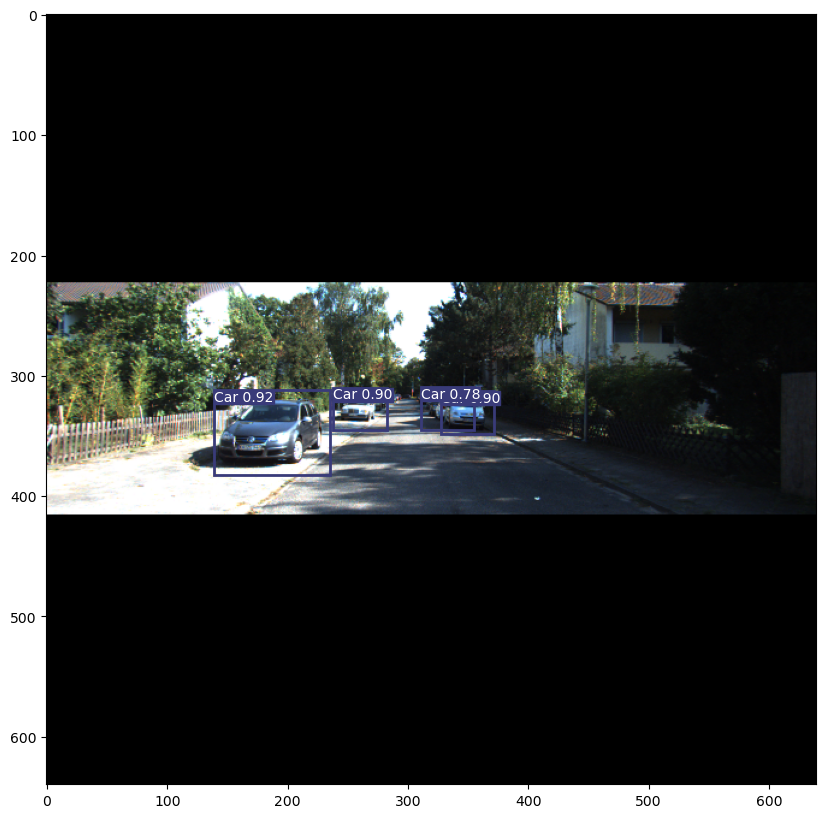

005554.png


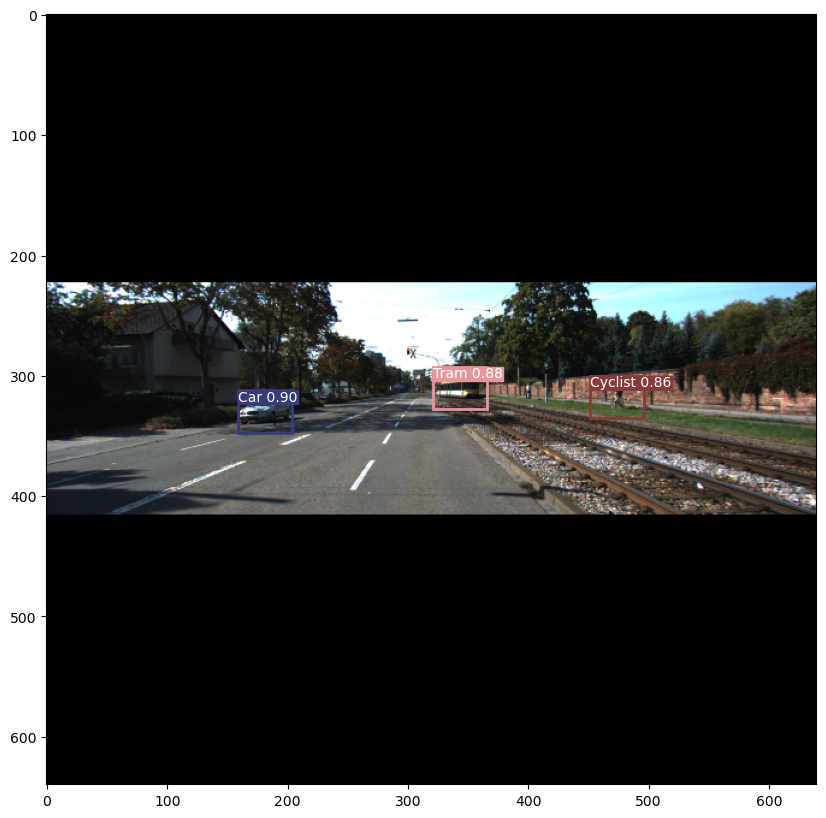

001386.png


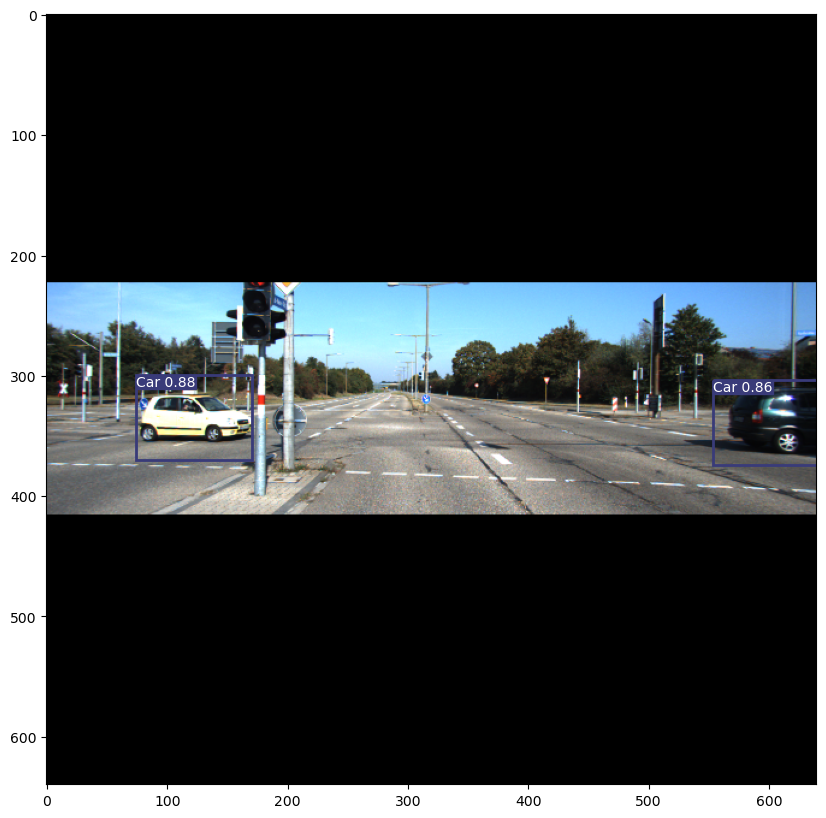

006339.png


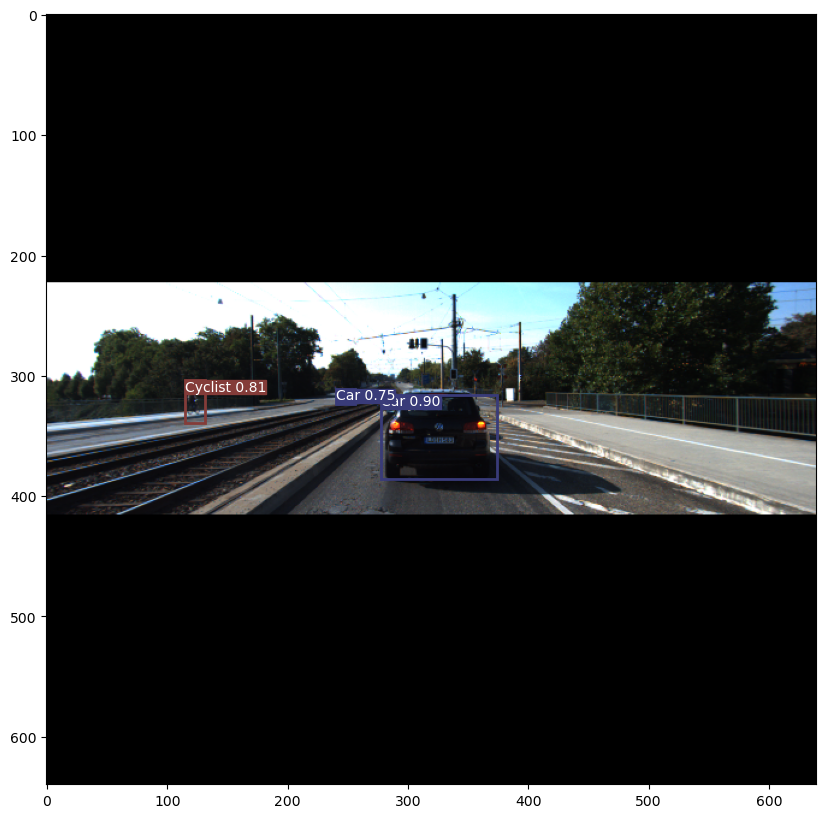

000854.png


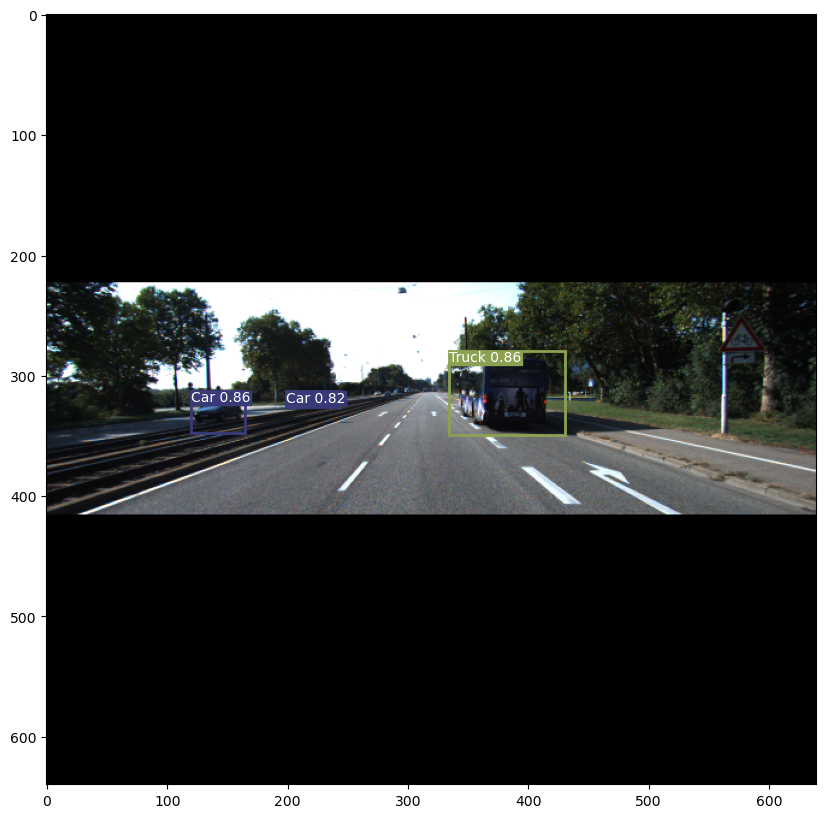

006934.png


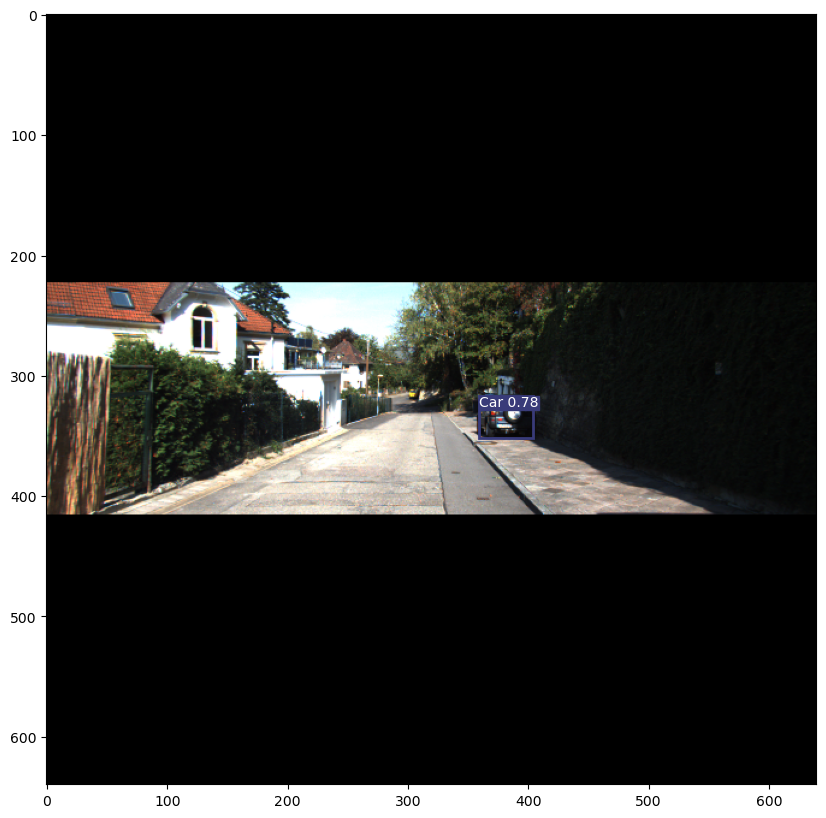

005333.png


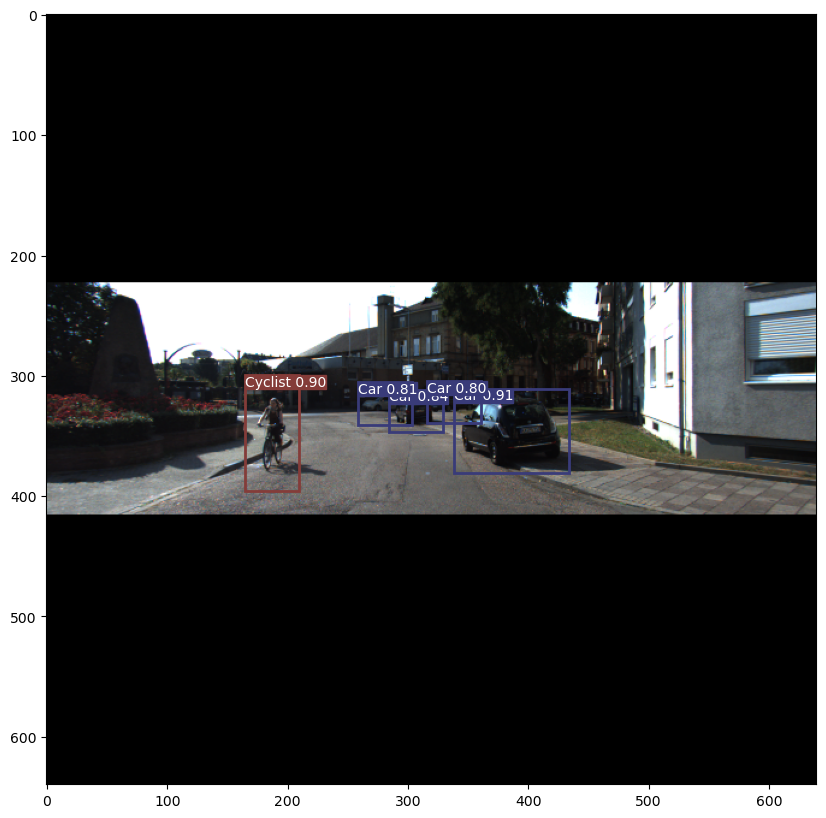

003930.png


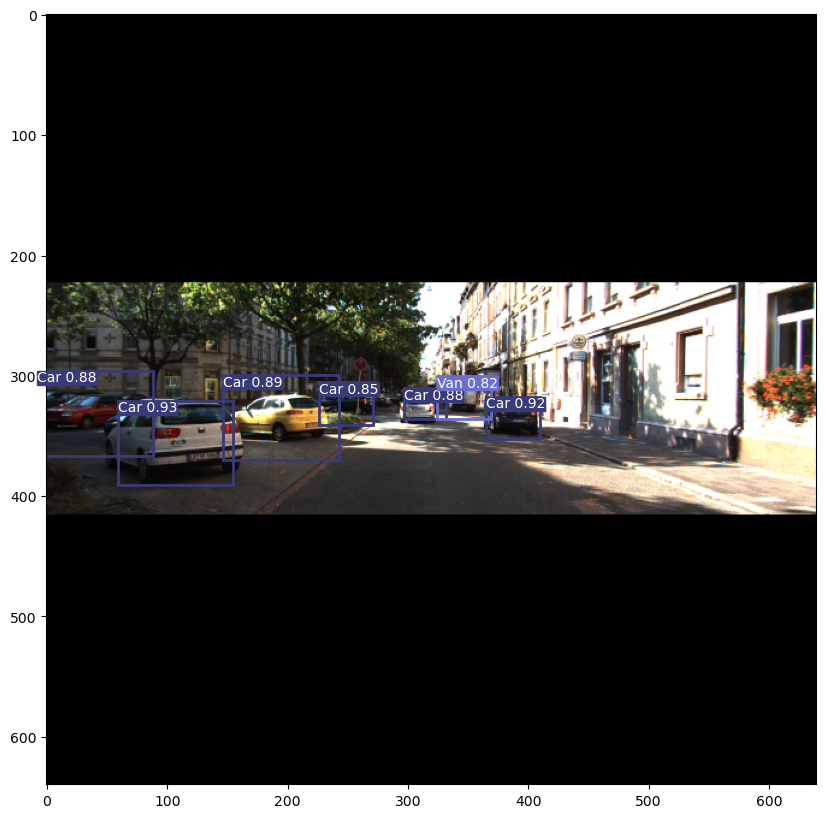

In [36]:
IOU_TRESH = 0.75
THRESH = 0.45
  
test_dataset = MelNetDataset(
    transforms=test_transforms,
    S=[RESIZE_TO // 32, RESIZE_TO // 16],
    img_dir=valid_data_path,
    label_dir=valid_lbl_path,
    anchors=ANCHORS,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

scaled_anchors = (
    torch.tensor(ANCHORS) * torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(DEVICE)
   
plot_couple_examples1(model, test_loader, IOU_TRESH, THRESH, scaled_anchors)
